In [2]:
run unified_pr.py

# Supercomputer run: 0.5 sim time units

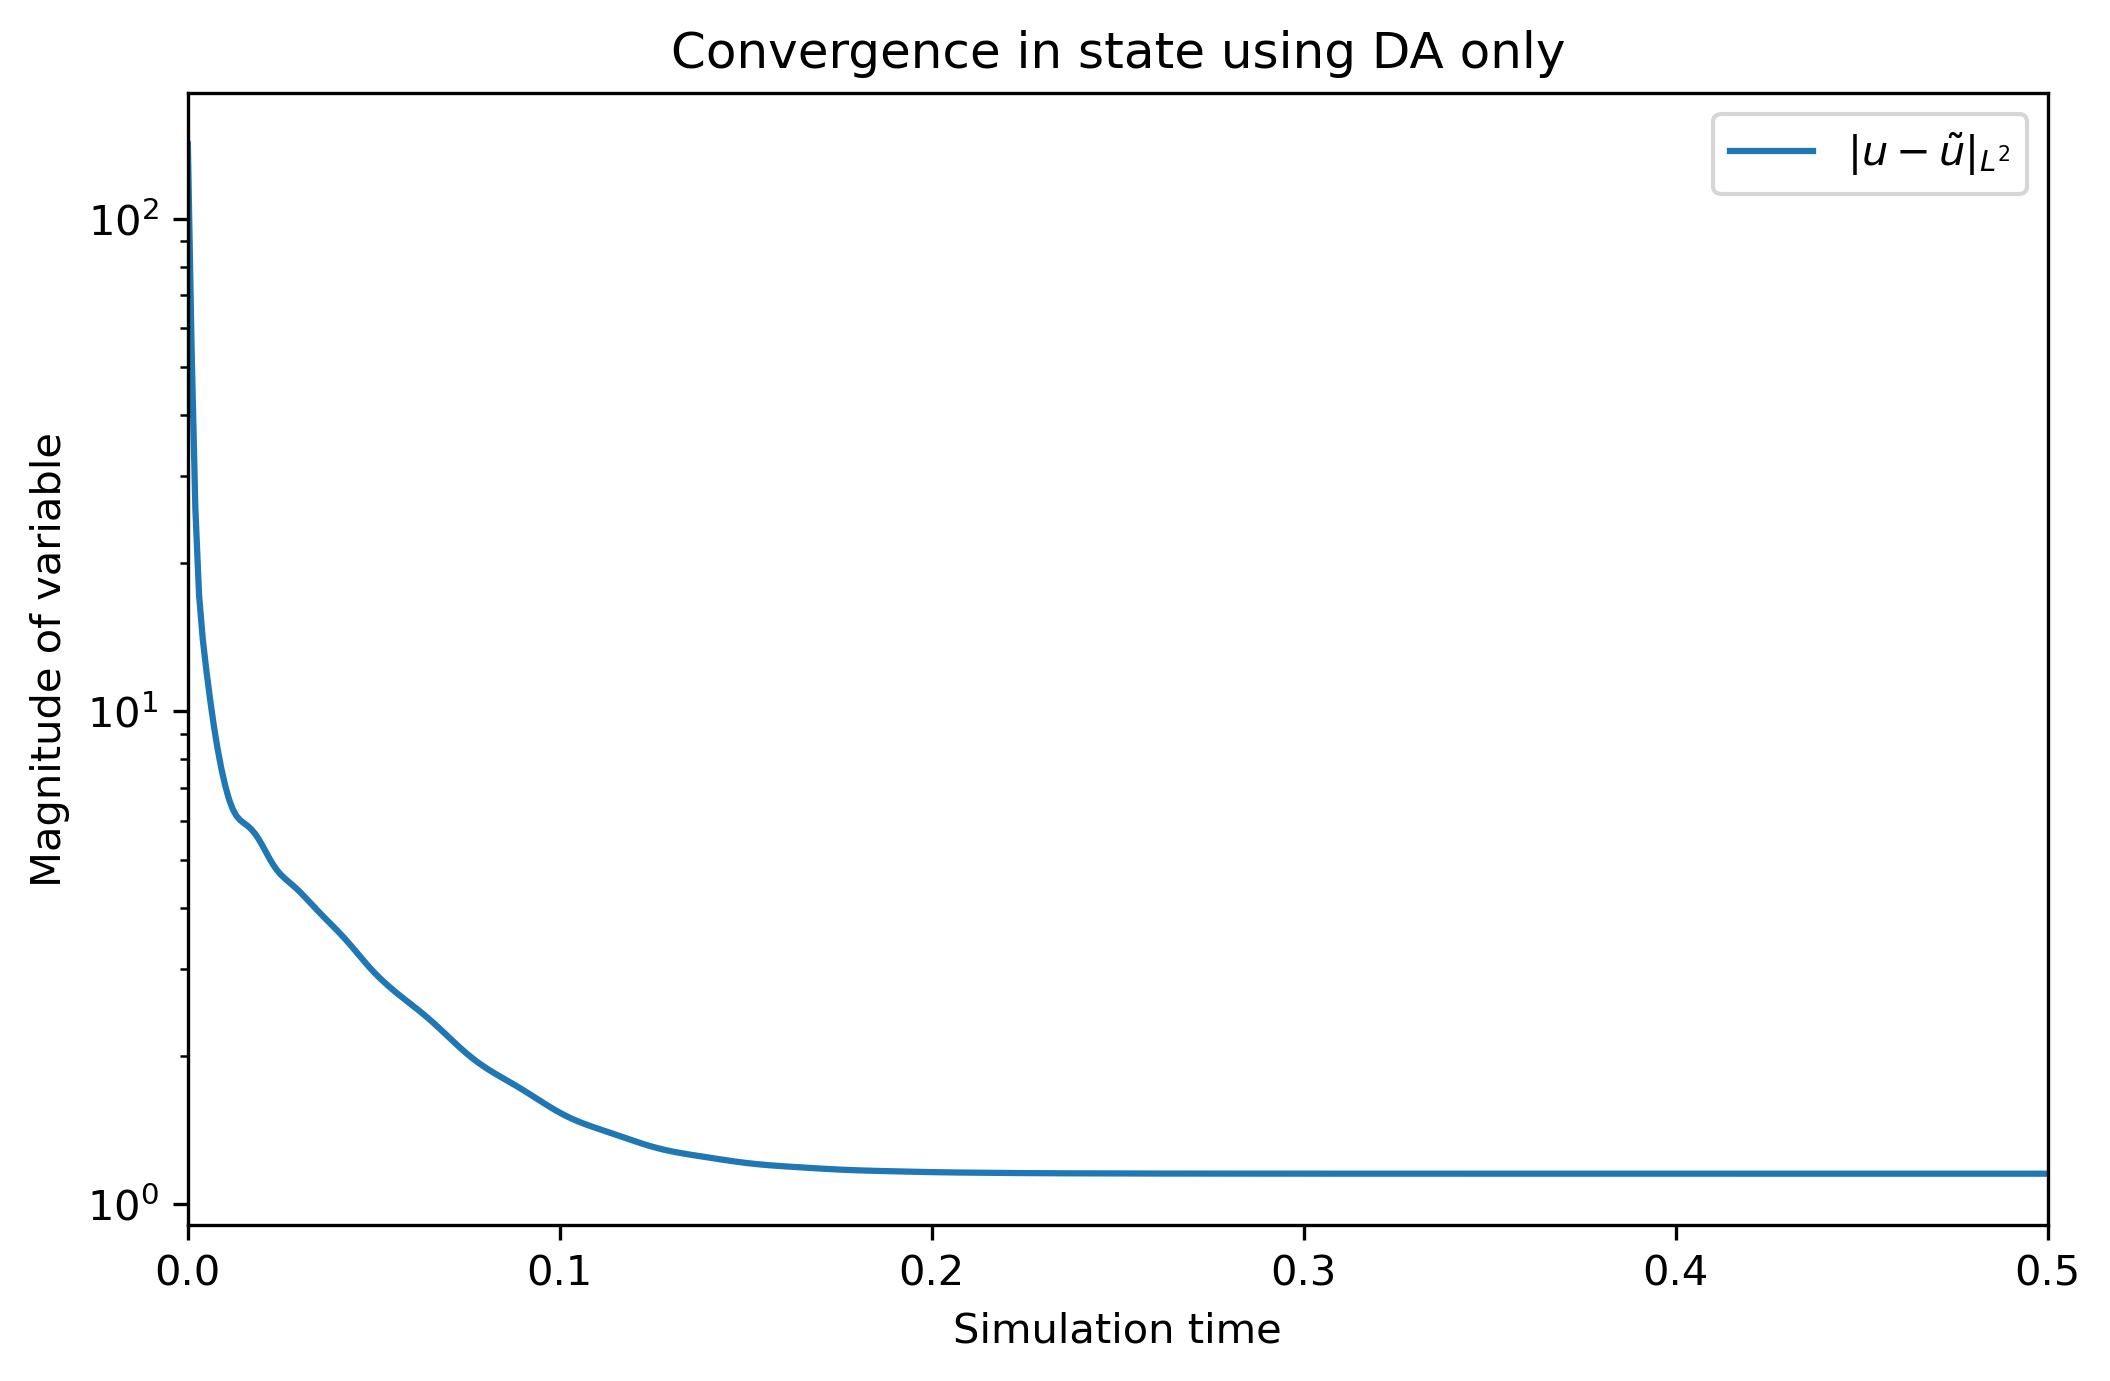

In [258]:
# RB_2D_PR__05_26_2022__04_19 is a supercomputer run starting from 
#ic = start_from('RB2D_Ra1e5_3_0.4_1/states/states.h5')
#ic.add_assim(start_from('RB2D_Ra8e4_4_0.3_1/states/states.h5'))
# with mu = 1000, Rayleigh=1e5, Ra_guess=9e4


with h5py.File('RB_2D_PR__05_26_2022__04_19/states/states.h5', 'r') as states, h5py.File('RB_2D_PR__05_26_2022__04_19/analysis/analysis.h5', 'r') as analysis:
    
    states_zeta = states['tasks/zeta']
    states_zeta_ = states['tasks/zeta']
    
    u_err = np.array(analysis['tasks/u_err'])
    #zeta_err = np.array(analysis['tasks/zeta_err'])
    
    sim_time = np.array(states['scales/sim_time'])

plt.figure(figsize=(8,5), dpi=300)
plt.semilogy(sim_time[:], u_err[:, 0, 0], label=r'$\|u-\tilde{u}\|_{L^2}$')
plt.legend(loc='upper right')
plt.xlim(0, 0.5)
plt.title('Convergence in state using DA only')
plt.ylabel('Magnitude of variable')
plt.xlabel('Simulation time')
plt.show()

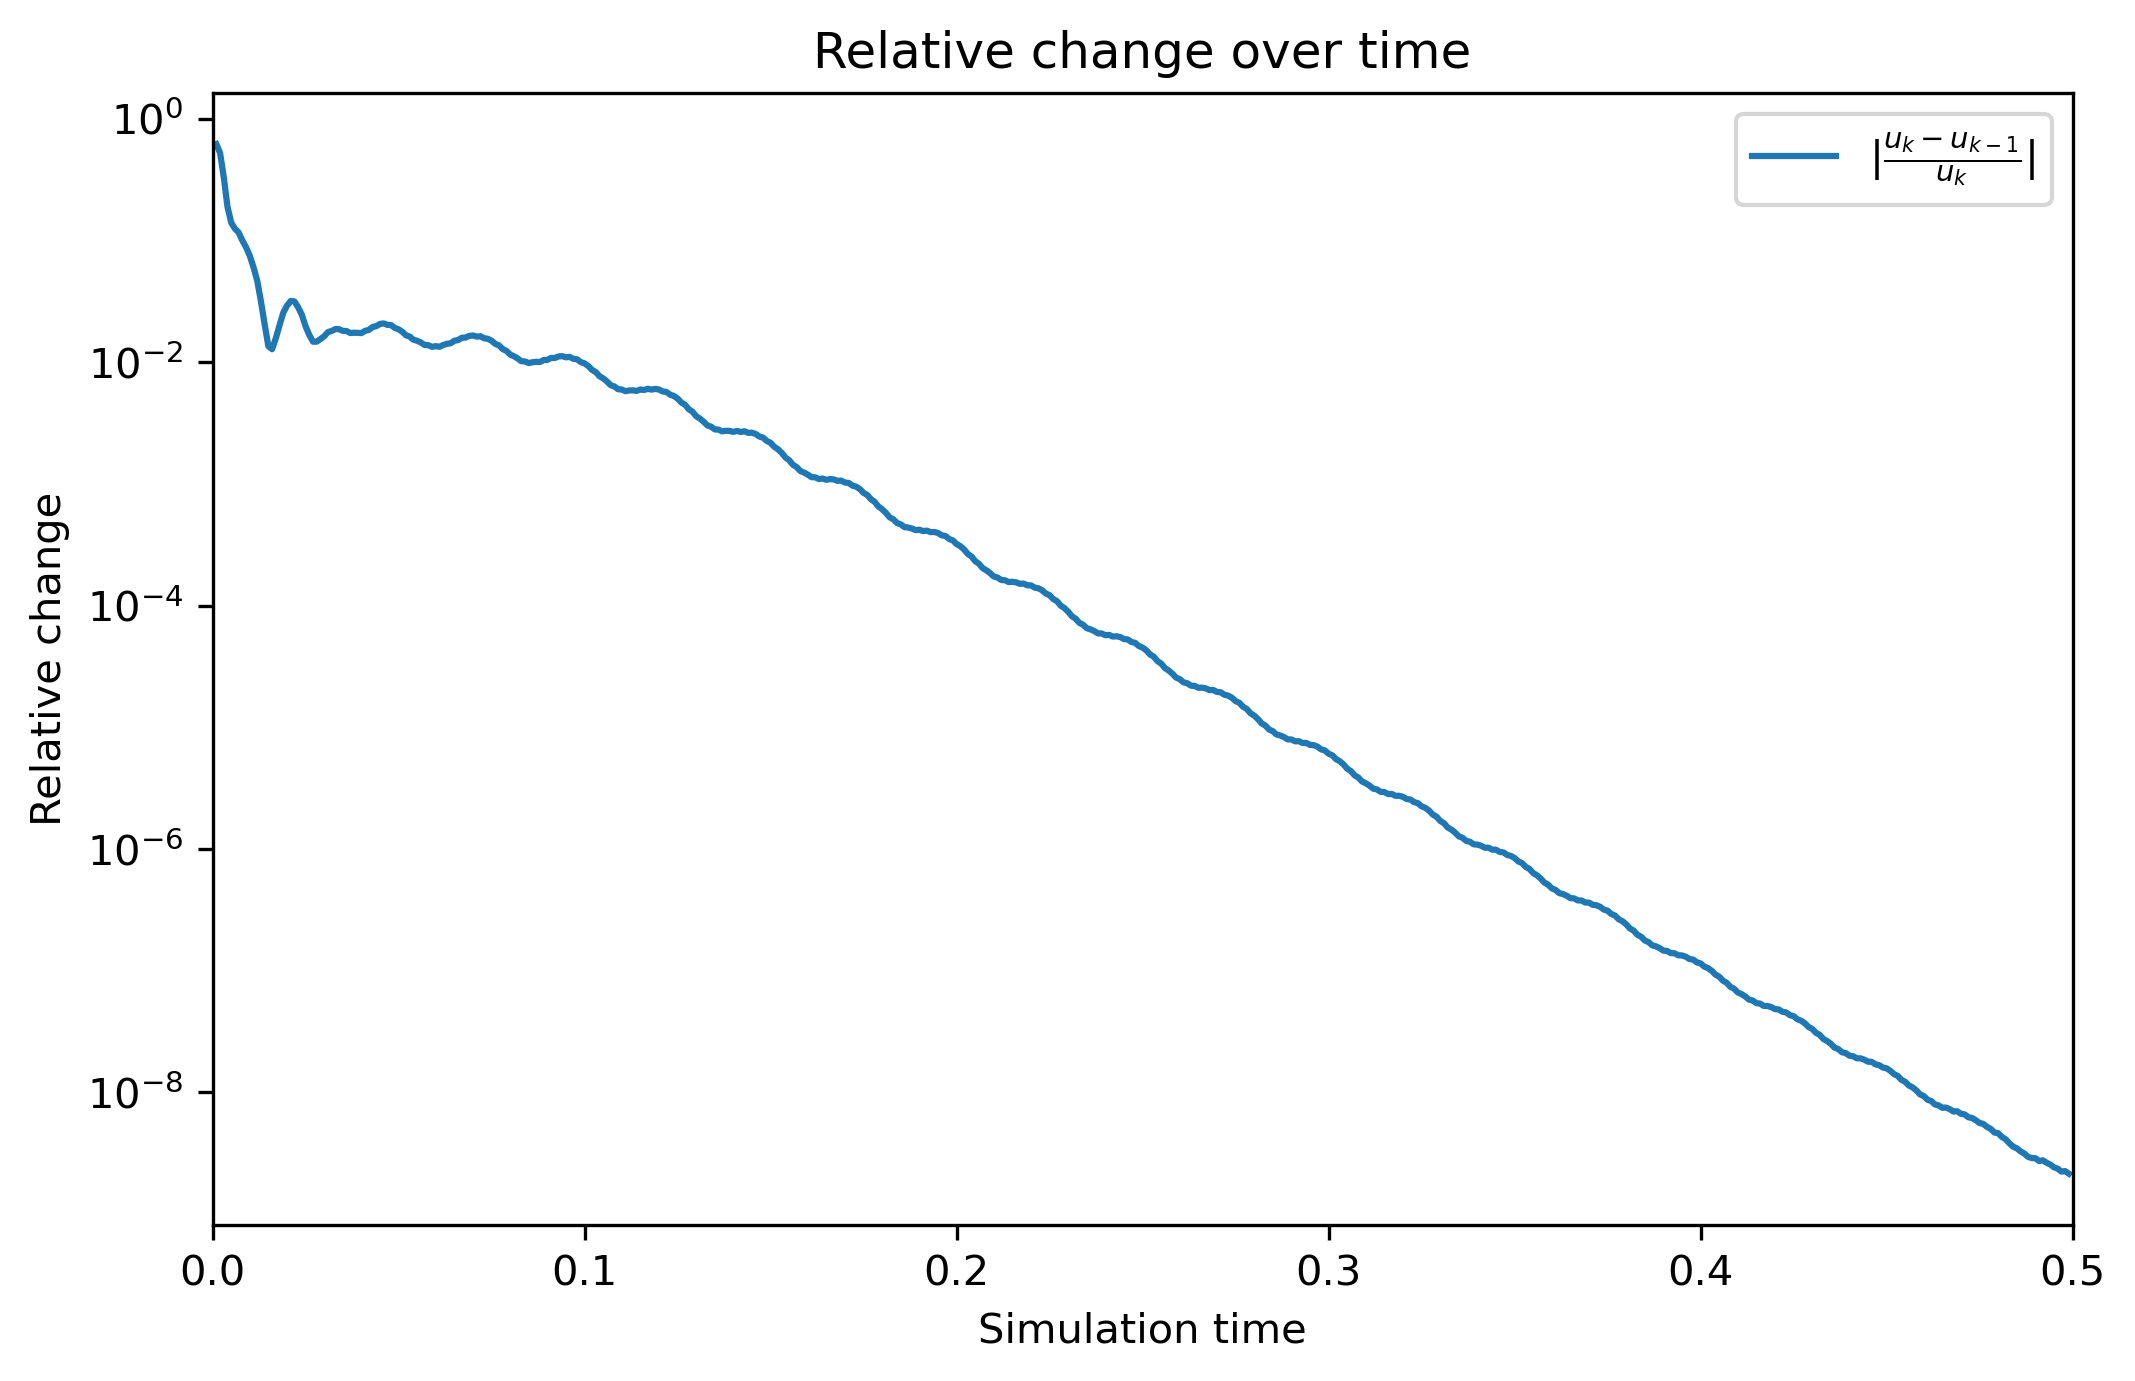

In [4]:
plt.figure(figsize=(8,5), dpi=300)
plt.semilogy(sim_time[1:], np.abs((u_err[1:, 0, 0] - u_err[:-1, 0, 0])/(u_err[:-1, 0, 0])), label=r'$\|\frac{u_k - u_{k-1}}{u_k}\|$')
plt.legend(loc='upper right')
plt.xlim(0, 0.5)
plt.title('Relative change over time')
plt.ylabel('Relative change')
plt.xlabel('Simulation time')
plt.show()

In [232]:
# Run a test a little further so we have access to the state variables inside of a dedalus problem
test = RB_2D_PR(Rayleigh=1e5, Ra_guess=9e4)

ic = start_from('RB_2D_PR__05_26_2022__04_19/states/states.h5')

test.setup_simulation(sim_time=1, wall_time=5*60, ic=ic, save=1e-8, mu=1000)
#test.run_simulation()

Created new directory RB_2D_PR__05_31_2022__12_19
2022-05-31 12:19:51,032 RB_2D_PR__05_31_2022__12_190 0/1 INFO :: BaseSimulator constructed
2022-05-31 12:19:51,058 RB_2D_PR__05_31_2022__12_190 0/1 INFO :: Parameters set up
2022-05-31 12:19:51,167 RB_2D_PR__05_31_2022__12_190 0/1 INFO :: Auxiliary equations and BCs set up
2022-05-31 12:19:51,181 RB_2D_PR__05_31_2022__12_190 0/1 INFO :: Evolution equations constructed
2022-05-31 12:19:51,182 RB_2D_PR__05_31_2022__12_190 0/1 INFO :: Writing parameters to 'RB_2D_PR__05_31_2022__12_19/params.json'
2022-05-31 12:19:51,183 RB_2D_PR__05_31_2022__12_190 0/1 INFO :: 	'L': 4.0
2022-05-31 12:19:51,185 RB_2D_PR__05_31_2022__12_190 0/1 INFO :: 	'xsize': 384
2022-05-31 12:19:51,188 RB_2D_PR__05_31_2022__12_190 0/1 INFO :: 	'zsize': 192
2022-05-31 12:19:51,191 RB_2D_PR__05_31_2022__12_190 0/1 INFO :: 	'Ra': 100000.0
2022-05-31 12:19:51,193 RB_2D_PR__05_31_2022__12_190 0/1 INFO :: 	'Pr': 1.0
2022-05-31 12:19:51,196 RB_2D_PR__05_31_2022__12_190 0/1 INF

## Linearized Update

In [ ]:
# New projection
def proj(F, N, return_field=False):
    """
    Calculate the Fourier mode projection of F with N terms.
    """
    # Evaluate if necessary
    if type(F) != core.field.Field: F = F.evaluate()
    
    # Set F scale
    F.set_scales(1)
    
    # Get indices
    X, Y = np.indices(F['c'].shape)
    
    # Create new field
    f = F.domain.new_field()
    
    # Project the low modes (<= N in both directions) 
    f['c'][(X <= N) | (Y <= N)] = F['c'][(X <= N) | (Y <= N)]

    # Return resulting field
    if return_field:
        return f
    else:
        return f['g']

In [249]:
proj_zeta_err = proj(test.solver.state['zeta']-test.solver.state['zeta_'], test.N, return_field=True)

proj_zeta_laplace_err = proj(test.solver.state['zeta'].differentiate(z=2) + test.solver.state['zeta'].differentiate(x=2) - test.solver.state['zeta_'].differentiate(z=2) - test.solver.state['zeta_'].differentiate(x=2), test.N, return_field=True)

proj_T_err = proj(test.solver.state['T']-test.solver.state['T_'], test.N, return_field=True)

Ih_temp__x = proj(test.solver.state['T_'].differentiate(x=1), test.N, return_field=True)

Ih_temp_x = proj(test.solver.state['T'].differentiate(x=1), test.N, return_field=True)

Ih_laplace_temp_ = proj(test.solver.state['T_'].differentiate(x=2) + test.solver.state['T_'].differentiate(z=2), test.N, return_field=True)

Ih_u_dot_grad_zeta = proj(-test.solver.state['psi'].differentiate(z=1)*test.solver.state['zeta'].differentiate(x=1) + test.solver.state['psi'].differentiate(x=1)*test.solver.state['zeta'].differentiate(z=1), test.N, return_field=True)

Ih_u_dot_grad_zeta_ = proj(-test.solver.state['psi_'].differentiate(z=1)*test.solver.state['zeta_'].differentiate(x=1) + test.solver.state['psi_'].differentiate(x=1)*test.solver.state['zeta_'].differentiate(z=1), test.N, return_field=True)

Ih_u_dot_grad_w = proj(-test.solver.state['psi'].differentiate(z=1)*(test.solver.state['zeta'].differentiate(x=1) - test.solver.state['zeta_'].differentiate(x=1)) + test.solver.state['psi'].differentiate(x=1)*(test.solver.state['zeta'].differentiate(z=1) - test.solver.state['zeta_'].differentiate(z=1)), test.N, return_field=True)

Ih_v_dot_grad_zeta_ = proj((-test.solver.state['psi'].differentiate(z=1)+test.solver.state['psi_'].differentiate(z=1))*test.solver.state['zeta_'].differentiate(x=1) + (test.solver.state['psi'].differentiate(x=1)-test.solver.state['psi_'].differentiate(x=1))*test.solver.state['zeta_'].differentiate(z=1), test.N, return_field=True)

In [256]:
a = de.operators.integrate(Ih_u_dot_grad_w * proj_zeta_err)['g'][0,0]
b = de.operators.integrate(Ih_v_dot_grad_zeta_ * proj_zeta_err)['g'][0,0]


c = de.operators.integrate(proj_T_err.differentiate(x=1) * proj_zeta_err)['g'][0,0]
d = de.operators.integrate(Ih_temp__x*proj_zeta_err, 'x', 'z')['g'][0,0]
#e = -de.operators.integrate(proj_zeta_err.differentiate(z=1)**2 + proj_zeta_err.differentiate(x=1)**2, 'x', 'z')['g'][0,0]
e = de.operators.integrate(proj_zeta_laplace_err*proj_zeta_err, 'x', 'z')['g'][0,0]
f = de.operators.integrate(proj_zeta_err**2, 'x', 'z')['g'][0,0]

a_ = de.operators.integrate(Ih_u_dot_grad_zeta * proj_zeta_err)['g'][0,0]
b_ = de.operators.integrate(Ih_u_dot_grad_zeta_ * proj_zeta_err)['g'][0,0]

c_ = de.operators.integrate(Ih_temp_x * proj_zeta_err)['g'][0,0]
d_ = de.operators.integrate(Ih_temp__x * proj_zeta_err)['g'][0,0]

- a - b + Pr*Ra*c + Pr*(Ra-Ra_)*d + Pr*e - test.mu * f
- a_ + b_ + Pr*Ra*c_ - Pr*Ra_*d_ + Pr*e - test.mu * f

-475.72545966581674

In [253]:
# Should equal 0
- a_ + b_ + Pr*Ra*c_ - Pr*Ra_*d_ + Pr*e - test.mu * f

-475.72545966581674

In [254]:
# Should give estimate for Ra
(a_ - b_ + Pr*Ra_*d_ - Pr*e + test.mu*f)/(Pr*c_)

100041.36900484476

In [264]:
# Simplified formula for Ra update (all quadratic terms removed)
Ra_ + test.mu*f/d

106623.82457954787

In [160]:
# Slightly less simplified formula for Ra update
(Ra_*d + test.mu*f)/(d+c)

99908.46356794453

## Experiments

In [103]:
A = np.array(proj_zeta_err['g'])

In [104]:
A

array([[2.56033767, 2.53161859, 2.47447814, ..., 2.4601077 , 2.50605074,
        2.52920566],
       [1.61569678, 1.59761614, 1.56164168, ..., 1.57914029, 1.60839321,
        1.6231361 ],
       [0.63751269, 0.6303843 , 0.61620108, ..., 0.62909294, 0.64070335,
        0.64655471],
       ...,
       [5.0118796 , 4.95481999, 4.84130368, ..., 4.37338911, 4.4593832 ,
        4.50272969],
       [4.27454377, 4.22618488, 4.12997408, ..., 3.88007809, 3.95470031,
        3.99231237],
       [3.45237417, 3.41350862, 3.33618238, ..., 3.23630603, 3.29749748,
        3.32833853]])

In [90]:
dx = 1/96
dz = 1/192

In [111]:
A.shape

(384, 192)

In [115]:
lA = (A[:-2, 1:-1] - 2*A[1:-1, 1:-1] + A[2:, 1:-1])/dx + (A[1:-1, :-2] - 2*A[1:-1, 1:-1] + A[1:-1, 2:])/dz

In [116]:
np.max(lA)

66.9787131889197

In [117]:
A.shape

(384, 192)

In [118]:
lA.shape

(382, 190)

In [120]:
# Estimate for inner product of A and laplace A (not accounting for Chebyshev grid effects)
np.sum(A[1:-1, 1:-1]*lA)*dx*dz

-151.23583808095032

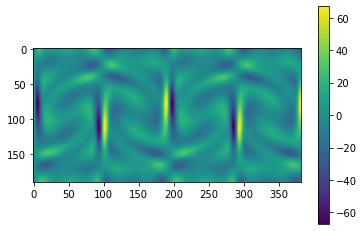

In [138]:
plt.imshow(np.rot90(lA))
plt.colorbar()

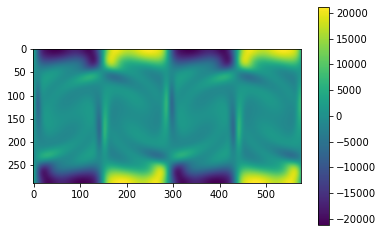

In [99]:
plt.imshow(np.rot90((proj_zeta_err.differentiate(z=2) + proj_zeta_err.differentiate(x=2))['g']))
plt.colorbar()

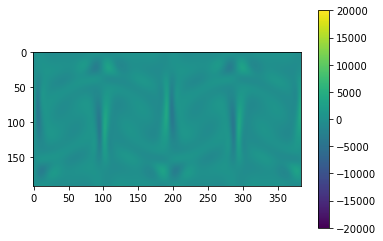

In [189]:
plt.imshow(np.rot90(proj_zeta_laplace_err['g']), vmin=-20000, vmax=20000)
plt.colorbar()

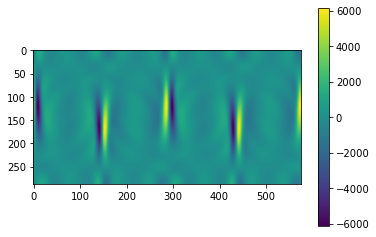

In [180]:
plt.imshow(np.rot90((proj_zeta_err.differentiate(x=2))['g']))
plt.colorbar()

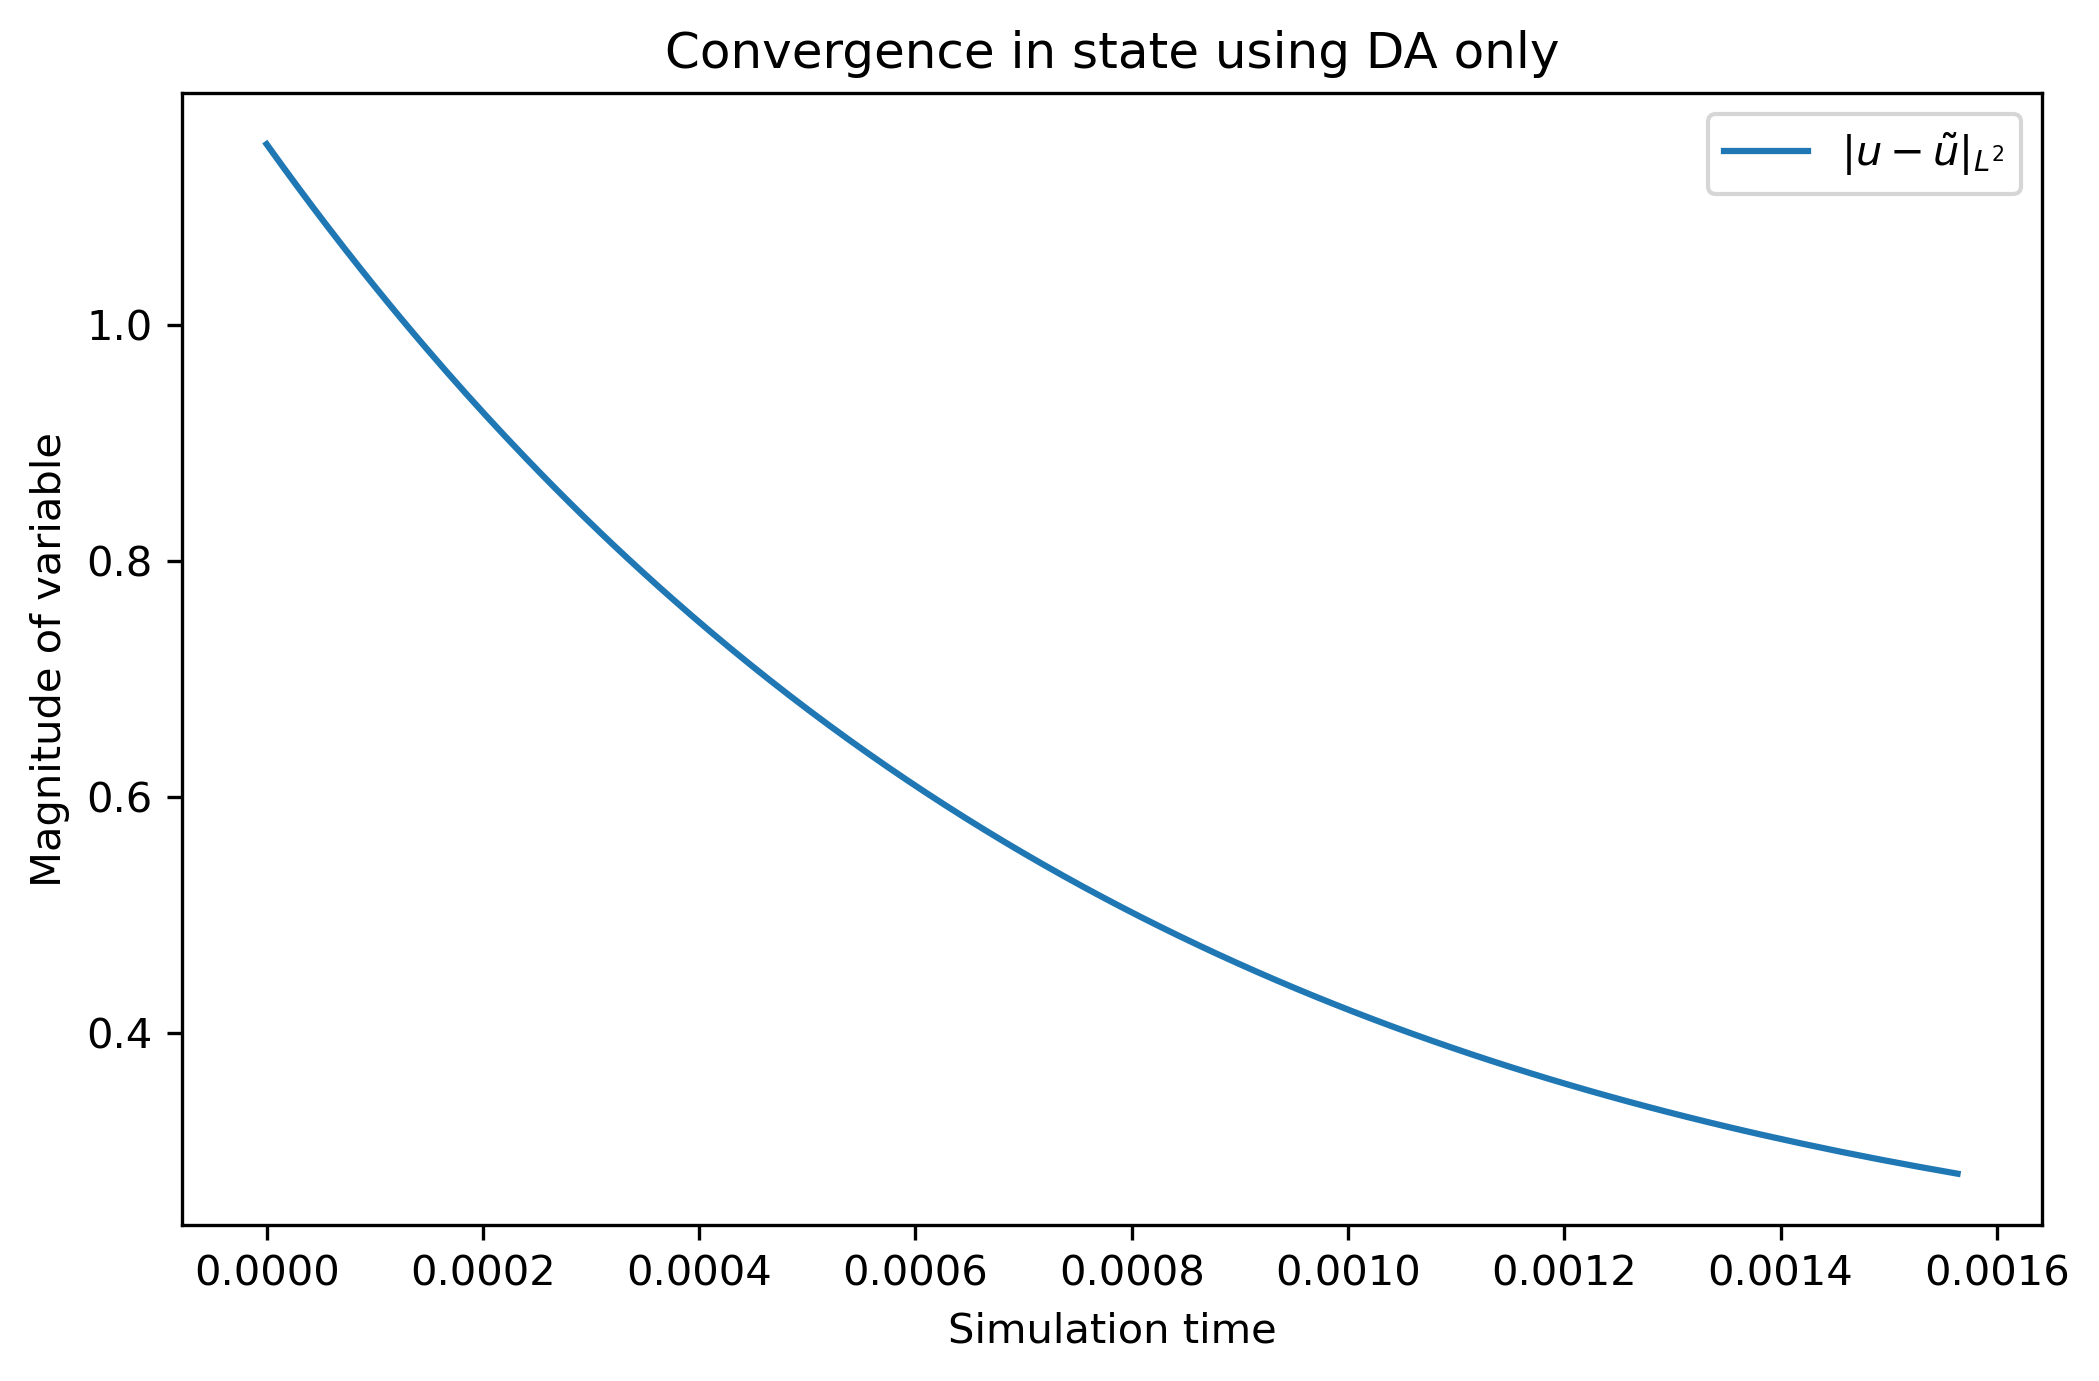

In [177]:

# Using updated Ra number of 99995

with h5py.File('RB_2D_PR__05_30_2022__14_02/states/states.h5', 'r') as states, h5py.File('RB_2D_PR__05_30_2022__14_02/analysis/analysis.h5', 'r') as analysis:
    
    states_zeta = states['tasks/zeta']
    states_zeta_ = states['tasks/zeta']
    
    u_err = np.array(analysis['tasks/u_err'])
    
    sim_time = np.array(states['scales/sim_time'])

plt.figure(figsize=(8,5), dpi=300)
plt.plot(sim_time[:], u_err[:, 0, 0], label=r'$\|u-\tilde{u}\|_{L^2}$')
plt.legend(loc='upper right')
#plt.xlim(0, 0.5)
plt.title('Convergence in state using DA only')
plt.ylabel('Magnitude of variable')
plt.xlabel('Simulation time')
plt.show()